<a href="https://colab.research.google.com/github/haruki0556/Chest_MRI/blob/main/Covid_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# 必要ライブラリ・コマンドの導入

!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1
w = !apt install tree
print(w[-2])

Setting up tree (2.0.2-1) ...


In [5]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

In [6]:
# PyTorch関連ライブラリのインポート

import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets

In [7]:
# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

In [8]:
# GPUチェック

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### 共通関数の読み込み

In [9]:
# 共通関数のダウンロード
!git clone https://github.com/haruki0556/Chest_MRI.git

# 共通関数のロード
from Chest_MRI.common_function.utils import *

# 共通関数の存在チェック
print(README)

Cloning into 'Chest_MRI'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 35 (delta 8), reused 24 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (35/35), 2.39 MiB | 29.85 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Hello!Haruki!


### サンプルデータのダウンロード・解凍

In [10]:
from google.colab import files
files.upload()

Saving Covid.zip to Covid.zip


In [11]:
# データ解凍
w = !unzip -o Covid.zip

# 結果確認
print(w[-1])

  inflating: Covid19-dataset/train/Viral Pneumonia/096.jpeg  


In [13]:
!ls

Chest_MRI  Covid19-dataset  Covid.zip  sample_data


In [15]:
import os

In [16]:
# =================================================================
# 3. ディレクトリ名 リネーム処理
# =================================================================

# ❗重要❗
# ZIP解凍後、クラス名フォルダ（例: cat, dog）が格納されている親ディレクトリのパスを設定してください。
# 例1: 解凍後 -> /extracted_dataset/cat, /extracted_dataset/dog の場合
data_root_dir1 = './Covid19-dataset/train'
data_root_dir2 = './Covid19-dataset/test'
# 例2: 解凍後 -> /extracted_dataset/images/cat, /extracted_dataset/images/dog の場合
# data_root_dir = './extracted_dataset/images/'

# リネームしたいクラス名の対応表
# キーが「現在のフォルダ名」、値が「新しいフォルダ名」です
rename_map = {
    'Covid': 'COV',
    'Normal': 'NML',
    'Viral Pneumonia':'VPNA'
    # 実際にご自身のデータに合わせて追記・修正してください
}
# =================================================================

print("\n--- ディレクトリ名 変更開始 ---")

for old_name, new_name in rename_map.items():
    old_path = os.path.join(data_root_dir1, old_name)
    new_path = os.path.join(data_root_dir1, new_name)

    # 変更元のフォルダが存在するかチェック
    if os.path.isdir(old_path):
        try:
            # os.rename() でフォルダ名を変更
            os.rename(old_path, new_path)
            print(f"✅ 成功: '{old_name}' -> '{new_name}'")
        except Exception as e:
            print(f"❌ エラー: '{old_name}' のリネーム中にエラーが発生しました: {e}")
    else:
        print(f"⚠️ スキップ: '{old_name}' というディレクトリは '{data_root_dir}' に存在しません。")

print("--- ディレクトリ名 変更完了 ---")

# =================================================================
# 4. 変更後のディレクトリ構造を再確認
# =================================================================
print("\n--- 変更後のディレクトリ構造 ---")
!ls -F {data_root_dir1}


--- ディレクトリ名 変更開始 ---
✅ 成功: 'Covid' -> 'COV'
✅ 成功: 'Normal' -> 'NML'
✅ 成功: 'Viral Pneumonia' -> 'VPNA'
--- ディレクトリ名 変更完了 ---

--- 変更後のディレクトリ構造 ---
COV/  NML/  VPNA/


In [17]:
print("\n--- ディレクトリ名 変更開始 ---")

for old_name, new_name in rename_map.items():
    old_path = os.path.join(data_root_dir2, old_name)
    new_path = os.path.join(data_root_dir2, new_name)

    # 変更元のフォルダが存在するかチェック
    if os.path.isdir(old_path):
        try:
            # os.rename() でフォルダ名を変更
            os.rename(old_path, new_path)
            print(f"✅ 成功: '{old_name}' -> '{new_name}'")
        except Exception as e:
            print(f"❌ エラー: '{old_name}' のリネーム中にエラーが発生しました: {e}")
    else:
        print(f"⚠️ スキップ: '{old_name}' というディレクトリは '{data_root_dir}' に存在しません。")

print("--- ディレクトリ名 変更完了 ---")

# =================================================================
# 4. 変更後のディレクトリ構造を再確認
# =================================================================
print("\n--- 変更後のディレクトリ構造 ---")
!ls -F {data_root_dir2}


--- ディレクトリ名 変更開始 ---
✅ 成功: 'Covid' -> 'COV'
✅ 成功: 'Normal' -> 'NML'
✅ 成功: 'Viral Pneumonia' -> 'VPNA'
--- ディレクトリ名 変更完了 ---

--- 変更後のディレクトリ構造 ---
COV/  NML/  VPNA/


In [18]:
# 解凍ファイルのtree表示
!tree Covid19-dataset

Covid19-dataset
├── test
│   ├── COV
│   │   ├── 0100.jpeg
│   │   ├── 0102.jpeg
│   │   ├── 0105.png
│   │   ├── 0106.jpeg
│   │   ├── 0108.jpeg
│   │   ├── 0111.jpg
│   │   ├── 0112.jpg
│   │   ├── 0113.jpg
│   │   ├── 0115.jpeg
│   │   ├── 0118.jpeg
│   │   ├── 0119.jpeg
│   │   ├── 0120.jpg
│   │   ├── 094.png
│   │   ├── 096.png
│   │   ├── 098.jpeg
│   │   ├── auntminnie-2020_01_31_20_24_2322_2020_01_31_x-ray_coronavirus_US.jpg
│   │   ├── auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg
│   │   ├── auntminnie-b-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg
│   │   ├── auntminnie-c-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg
│   │   ├── auntminnie-d-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg
│   │   ├── COVID-00003b.jpg
│   │   ├── COVID-00012.jpg
│   │   ├── COVID-00022.jpg
│   │   ├── COVID-00033.jpg
│   │   ├── COVID-00037.jpg
│   │   └── radiopaedia-2019-novel-coronavirus-infected-pneumonia.jpg
│   ├── NML
│   │  

### Transforms定義

In [34]:
# Transforms定義

# 検証データ用 : 正規化のみ実施
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

# 訓練データ用: 正規化に追加で反転とRandomErasingを実施
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

### データセット定義

In [35]:
# ツリーのベースディレクトリ
data_dir = 'Covid19-dataset'

# 訓練データディレクトリと検証データディレクトリの指定
import os
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# join関数の結果確認
print(train_dir, test_dir)

# 分類先クラスのリスト作成
classes = ['COV', 'NML','VPNA']

Covid19-dataset/train Covid19-dataset/test


In [36]:
# データセット定義

# 訓練用
train_data = datasets.ImageFolder(train_dir,
            transform=train_transform)
# 訓練データのイメージ表示用
train_data2 = datasets.ImageFolder(train_dir,
            transform=test_transform)
# 検証用
test_data = datasets.ImageFolder(test_dir,
            transform=test_transform)

In [37]:
# データ件数確認

print(f'訓練データ: {len(train_data)}件')
print(f'検証データ: {len(test_data)}件')

訓練データ: 251件
検証データ: 66件


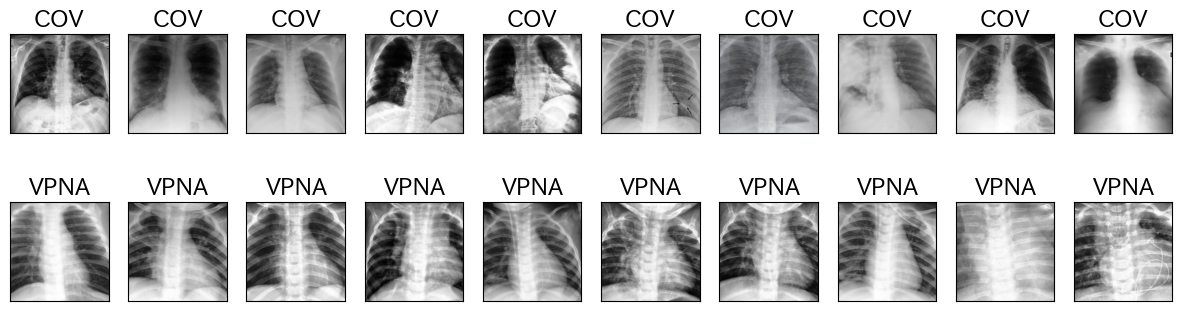

In [38]:
# 検証データ
# 最初の10個と最後の10個の表示

plt.figure(figsize=(15, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    image, label = test_data[i]
    img = (np.transpose(image.numpy(), (1, 2, 0)) + 1)/2
    plt.imshow(img)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 10, i + 11)
    image, label = test_data[-i-1]
    img = (np.transpose(image.numpy(), (1, 2, 0)) + 1)/2
    plt.imshow(img)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### データローダー定義

In [39]:
# データローダー定義

batch_size = 50

# 訓練用
train_loader = DataLoader(train_data,
      batch_size=batch_size, shuffle=True)

# 検証用
test_loader = DataLoader(test_data,
      batch_size=batch_size, shuffle=False)

# イメージ表示用
train_loader2 = DataLoader(train_data2,
      batch_size=50, shuffle=True)
test_loader2 = DataLoader(test_data,
      batch_size=50, shuffle=True)

### イメージ表示

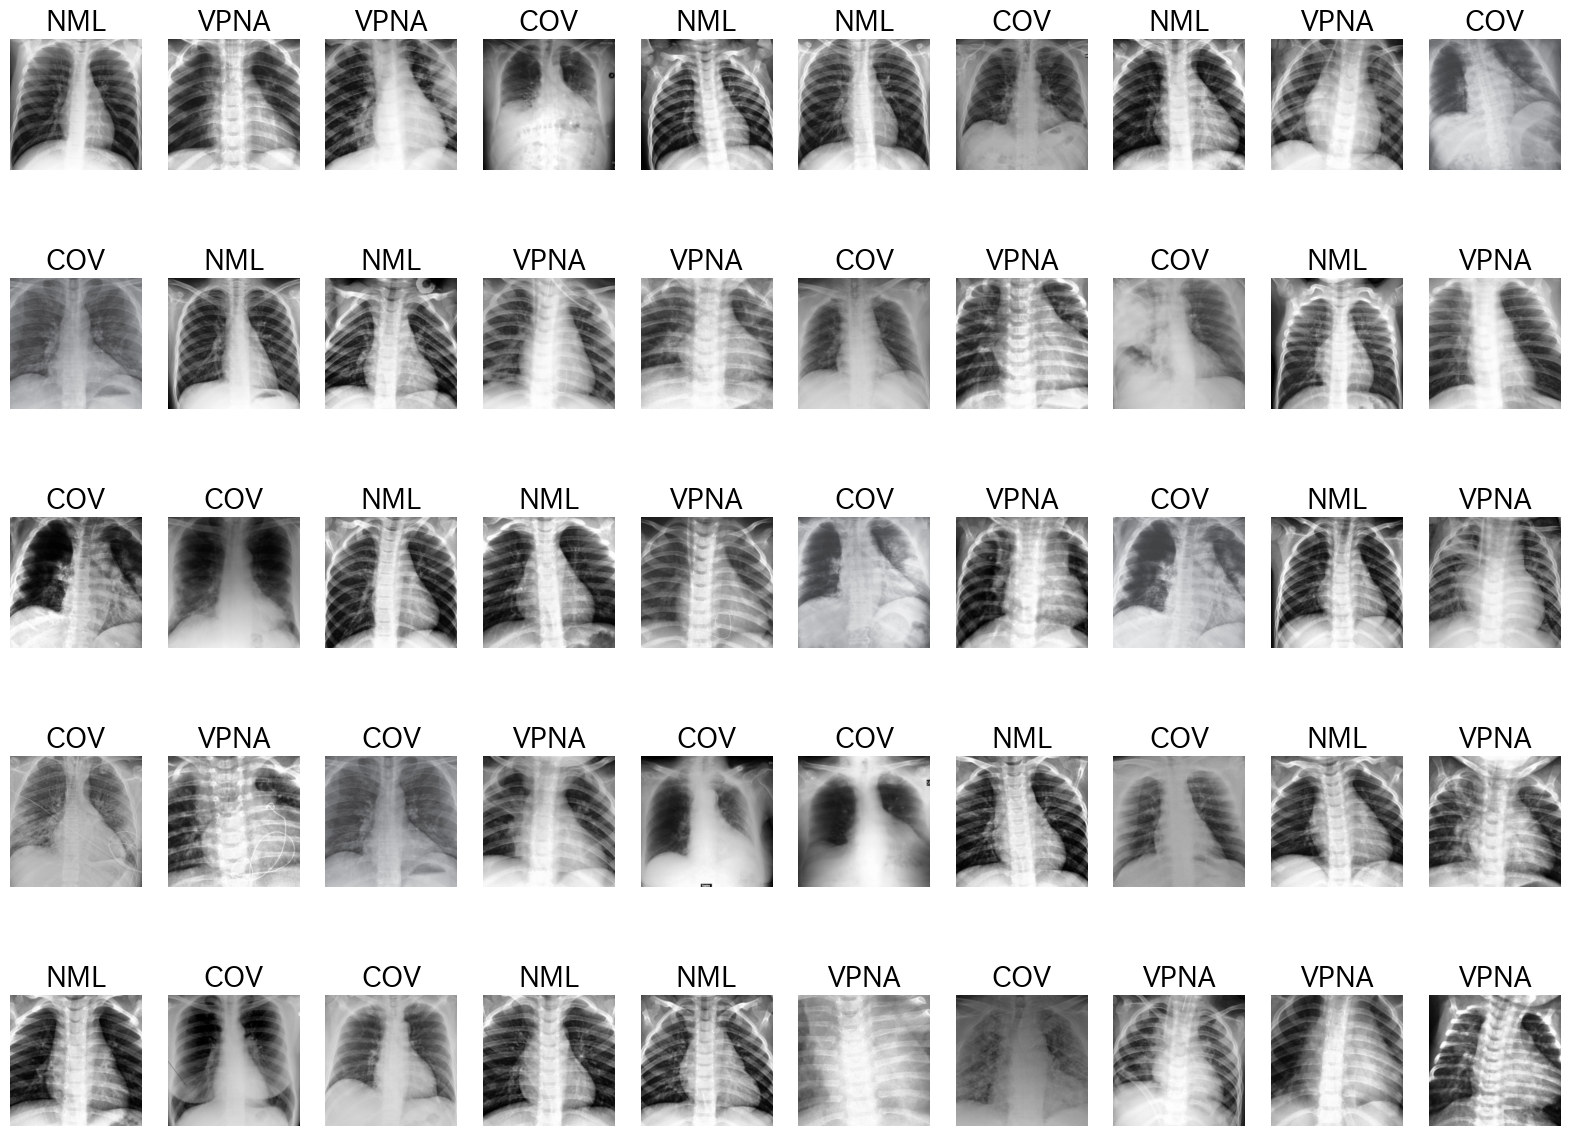

In [40]:
# 検証用データ(50件)
torch_seed()
show_images_labels(test_loader2, classes, None, None)

## ファインチューニング版

In [53]:
# ファインチューニング版

# 学習済みモデルの読み込み
# vgg19_bnをパラメータ付きで読み込む
from torchvision import models
net = models.vgg19_bn(pretrained = True)

# 乱数初期化
torch_seed()

# 最終ノードの出力を2に変更する
in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, 3)

# AdaptiveAvgPool2d関数の取り外し
net.avgpool = nn.Identity()

# GPUの利用
net = net.to(device)

# 学習率
lr = 0.0001

# 損失関数定義
criterion = nn.CrossEntropyLoss()

# 最適化関数定義
optimizer = optim.SGD(net.parameters(),lr=lr,momentum=0.9)

# historyファイルも同時に初期化する
history = np.zeros((0, 5))

In [54]:
# 学習
num_epochs = 20
history = fit(net, optimizer, criterion, num_epochs,
          train_loader, test_loader, device, history)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[1/20],loss:1.13691 acc:0.28685 test_loss:1.1345006949973828 test_acc:0.33333


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[2/20],loss:1.12159 acc:0.31076 test_loss:1.094038649038835 test_acc:0.39394


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[3/20],loss:1.09391 acc:0.42231 test_loss:1.0678099140976414 test_acc:0.39394


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[4/20],loss:1.06526 acc:0.42629 test_loss:1.0657933661431978 test_acc:0.33333


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[5/20],loss:1.04635 acc:0.46614 test_loss:1.0444687315911958 test_acc:0.39394


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[6/20],loss:1.01864 acc:0.52590 test_loss:1.0303836085579612 test_acc:0.40909


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[7/20],loss:1.02278 acc:0.46614 test_loss:1.0108225345611572 test_acc:0.50000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[8/20],loss:1.01180 acc:0.52988 test_loss:0.9763270797151508 test_acc:0.60606


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[9/20],loss:0.96703 acc:0.56972 test_loss:0.9452551115642894 test_acc:0.71212


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[10/20],loss:0.93312 acc:0.62948 test_loss:0.9097975564725471 test_acc:0.69697


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[11/20],loss:0.96131 acc:0.59363 test_loss:0.8837873249342947 test_acc:0.69697


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[12/20],loss:0.89218 acc:0.66135 test_loss:0.8588035160844977 test_acc:0.69697


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[13/20],loss:0.87930 acc:0.63745 test_loss:0.8359937776218761 test_acc:0.66667


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[14/20],loss:0.87346 acc:0.62550 test_loss:0.8101890755422188 test_acc:0.68182


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[15/20],loss:0.84276 acc:0.65737 test_loss:0.7929868373003873 test_acc:0.84848


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[16/20],loss:0.82198 acc:0.67729 test_loss:0.7650174299875895 test_acc:0.87879


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[17/20],loss:0.78513 acc:0.72908 test_loss:0.7335821968136411 test_acc:0.87879


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[18/20],loss:0.78397 acc:0.70120 test_loss:0.7118701302643978 test_acc:0.87879


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[19/20],loss:0.77441 acc:0.69323 test_loss:0.6833742983413466 test_acc:0.86364


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[20/20],loss:0.72676 acc:0.73705 test_loss:0.6741311532078367 test_acc:0.86364


In [55]:
# 追加学習
num_epochs = 30
history = fit(net, optimizer, criterion, num_epochs,
          train_loader, test_loader, device, history)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[21/50],loss:0.71386 acc:0.76494 test_loss:0.6721438765525818 test_acc:0.84848


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[22/50],loss:0.73102 acc:0.73307 test_loss:0.6589261708837567 test_acc:0.75758


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[23/50],loss:0.68761 acc:0.77291 test_loss:0.6421032403454636 test_acc:0.84848


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[24/50],loss:0.74054 acc:0.68526 test_loss:0.6260814251321735 test_acc:0.81818


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[25/50],loss:0.70250 acc:0.75299 test_loss:0.5950640494173224 test_acc:0.87879


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[26/50],loss:0.66209 acc:0.76096 test_loss:0.6039353103348704 test_acc:0.83333


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[27/50],loss:0.63003 acc:0.80478 test_loss:0.5680512207927126 test_acc:0.86364


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[28/50],loss:0.64121 acc:0.71713 test_loss:0.5353375691356081 test_acc:0.86364


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[29/50],loss:0.60966 acc:0.78884 test_loss:0.5234202534863444 test_acc:0.92424


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[30/50],loss:0.60586 acc:0.76892 test_loss:0.5190392615217151 test_acc:0.90909


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[31/50],loss:0.59950 acc:0.76892 test_loss:0.4974319510387652 test_acc:0.90909


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[32/50],loss:0.60054 acc:0.74104 test_loss:0.4801114933057265 test_acc:0.92424


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[33/50],loss:0.58418 acc:0.74900 test_loss:0.4779903870640379 test_acc:0.92424


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[34/50],loss:0.57809 acc:0.76494 test_loss:0.4710123963428266 test_acc:0.92424


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[35/50],loss:0.54585 acc:0.79681 test_loss:0.45173174775008 test_acc:0.92424


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[36/50],loss:0.56965 acc:0.79681 test_loss:0.44334902185382263 test_acc:0.93939


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[37/50],loss:0.54147 acc:0.80478 test_loss:0.4393164470340266 test_acc:0.87879


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[38/50],loss:0.53056 acc:0.80876 test_loss:0.46821883049878205 test_acc:0.84848


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[39/50],loss:0.53252 acc:0.80876 test_loss:0.45639536236271716 test_acc:0.80303


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[40/50],loss:0.50953 acc:0.82869 test_loss:0.42496391769611475 test_acc:0.84848


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[41/50],loss:0.46652 acc:0.84861 test_loss:0.38898549928809656 test_acc:0.95455


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[42/50],loss:0.46698 acc:0.84462 test_loss:0.3740863791017821 test_acc:0.89394


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[43/50],loss:0.50916 acc:0.82869 test_loss:0.37468792633576825 test_acc:0.92424


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[44/50],loss:0.45444 acc:0.85259 test_loss:0.38582957513404614 test_acc:0.92424


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[45/50],loss:0.46272 acc:0.82869 test_loss:0.36810095111529034 test_acc:0.93939


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[46/50],loss:0.45915 acc:0.82869 test_loss:0.3545597556865577 test_acc:0.95455


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[47/50],loss:0.48590 acc:0.80876 test_loss:0.36890430612997577 test_acc:0.87879


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[48/50],loss:0.45685 acc:0.84861 test_loss:0.344574971632524 test_acc:0.93939


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[49/50],loss:0.43794 acc:0.82470 test_loss:0.34385278008200904 test_acc:0.93939


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[50/50],loss:0.45112 acc:0.84861 test_loss:0.33657681941986084 test_acc:0.93939


In [57]:
# 追加学習
num_epochs = 50
history = fit(net, optimizer, criterion, num_epochs,
          train_loader, test_loader, device, history)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[51/100],loss:0.41118 acc:0.86853 test_loss:0.3488193822629524 test_acc:0.92424


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[52/100],loss:0.40189 acc:0.85657 test_loss:0.3585108861778722 test_acc:0.90909


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[53/100],loss:0.38237 acc:0.84462 test_loss:0.3164629683350072 test_acc:0.95455


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[54/100],loss:0.36738 acc:0.88048 test_loss:0.30504385539979645 test_acc:0.95455


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[55/100],loss:0.42709 acc:0.82869 test_loss:0.35021974462451355 test_acc:0.89394


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[56/100],loss:0.39383 acc:0.84861 test_loss:0.29811669118476636 test_acc:0.92424


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[57/100],loss:0.39155 acc:0.86056 test_loss:0.3086109459400177 test_acc:0.90909


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[58/100],loss:0.42747 acc:0.84462 test_loss:0.3021251613443548 test_acc:0.93939


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[59/100],loss:0.38504 acc:0.87251 test_loss:0.31372027144287573 test_acc:0.90909


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[60/100],loss:0.34349 acc:0.89243 test_loss:0.299236229874871 test_acc:0.90909


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[61/100],loss:0.38564 acc:0.86056 test_loss:0.30690905993635004 test_acc:0.86364


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[62/100],loss:0.34748 acc:0.88446 test_loss:0.2938477803360332 test_acc:0.92424


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[63/100],loss:0.39054 acc:0.84861 test_loss:0.27536975344022113 test_acc:0.93939


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[64/100],loss:0.35620 acc:0.86853 test_loss:0.3032645086447398 test_acc:0.87879


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[65/100],loss:0.36429 acc:0.87251 test_loss:0.28918751351761096 test_acc:0.90909


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[66/100],loss:0.33573 acc:0.87251 test_loss:0.30474111347487476 test_acc:0.84848


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[67/100],loss:0.31315 acc:0.89243 test_loss:0.277830059781219 test_acc:0.92424


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[68/100],loss:0.34189 acc:0.88446 test_loss:0.258562060919675 test_acc:0.93939


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[69/100],loss:0.30914 acc:0.88048 test_loss:0.29332781831423443 test_acc:0.87879


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[70/100],loss:0.31601 acc:0.88845 test_loss:0.2953671740763115 test_acc:0.92424


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[71/100],loss:0.33997 acc:0.88446 test_loss:0.26537396871682367 test_acc:0.92424


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[72/100],loss:0.32456 acc:0.87251 test_loss:0.22906469666596616 test_acc:0.95455


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[73/100],loss:0.31038 acc:0.90438 test_loss:0.22379389901955923 test_acc:0.93939


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[74/100],loss:0.32305 acc:0.88845 test_loss:0.23545243071787286 test_acc:0.92424


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[75/100],loss:0.30585 acc:0.87649 test_loss:0.21691529859196057 test_acc:0.96970


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[76/100],loss:0.28931 acc:0.92430 test_loss:0.23167138885368 test_acc:0.93939


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[77/100],loss:0.24846 acc:0.93227 test_loss:0.2315081132180763 test_acc:0.93939


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[78/100],loss:0.30728 acc:0.88845 test_loss:0.23559340112137073 test_acc:0.92424


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[79/100],loss:0.25914 acc:0.90837 test_loss:0.25305614507559576 test_acc:0.92424


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[80/100],loss:0.29105 acc:0.89641 test_loss:0.23319307150262775 test_acc:0.95455


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[81/100],loss:0.28499 acc:0.88845 test_loss:0.23317419444069717 test_acc:0.95455


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[82/100],loss:0.30772 acc:0.88845 test_loss:0.23890071746074792 test_acc:0.95455


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[83/100],loss:0.28175 acc:0.90438 test_loss:0.21399688449772922 test_acc:0.93939


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[84/100],loss:0.25703 acc:0.90438 test_loss:0.2135890577778672 test_acc:0.95455


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[85/100],loss:0.29465 acc:0.88446 test_loss:0.22556147611502445 test_acc:0.95455


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[86/100],loss:0.27387 acc:0.91633 test_loss:0.23873639919541098 test_acc:0.92424


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[87/100],loss:0.25956 acc:0.91633 test_loss:0.30768260540384235 test_acc:0.84848


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[88/100],loss:0.24699 acc:0.91235 test_loss:0.2350608968373501 test_acc:0.92424


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[89/100],loss:0.27647 acc:0.89641 test_loss:0.2163362783012968 test_acc:0.92424


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[90/100],loss:0.25183 acc:0.92032 test_loss:0.19941127480882587 test_acc:0.92424


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[91/100],loss:0.23528 acc:0.93227 test_loss:0.18168580441763907 test_acc:0.95455


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[92/100],loss:0.23857 acc:0.91235 test_loss:0.174330677950021 test_acc:0.96970


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[93/100],loss:0.23891 acc:0.92829 test_loss:0.20087954266504807 test_acc:0.95455


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[94/100],loss:0.27929 acc:0.88048 test_loss:0.17079849089636948 test_acc:0.95455


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[95/100],loss:0.24323 acc:0.92430 test_loss:0.14835385865334308 test_acc:0.96970


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[96/100],loss:0.27190 acc:0.88446 test_loss:0.15269154852086847 test_acc:0.95455


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[97/100],loss:0.23120 acc:0.92829 test_loss:0.20287068278500528 test_acc:0.89394


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[98/100],loss:0.24302 acc:0.90837 test_loss:0.21866186234084042 test_acc:0.90909


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[99/100],loss:0.27278 acc:0.90040 test_loss:0.16977636967644547 test_acc:0.93939


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[100/100],loss:0.23416 acc:0.92430 test_loss:0.1686509418668169 test_acc:0.96970


初期状態: 損失: 1.13450 精度: 0.33333
最終状態: 損失: 0.16865 精度: 0.96970


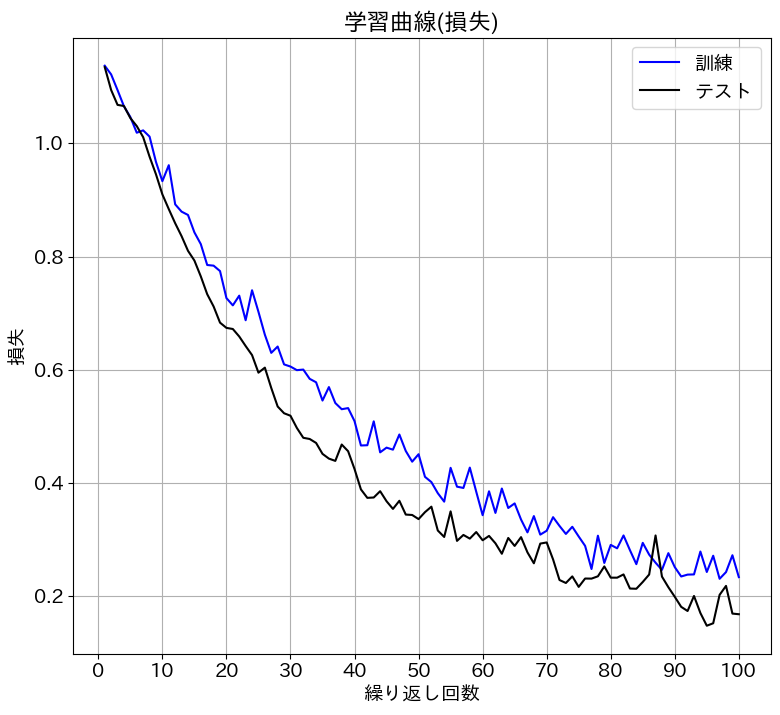

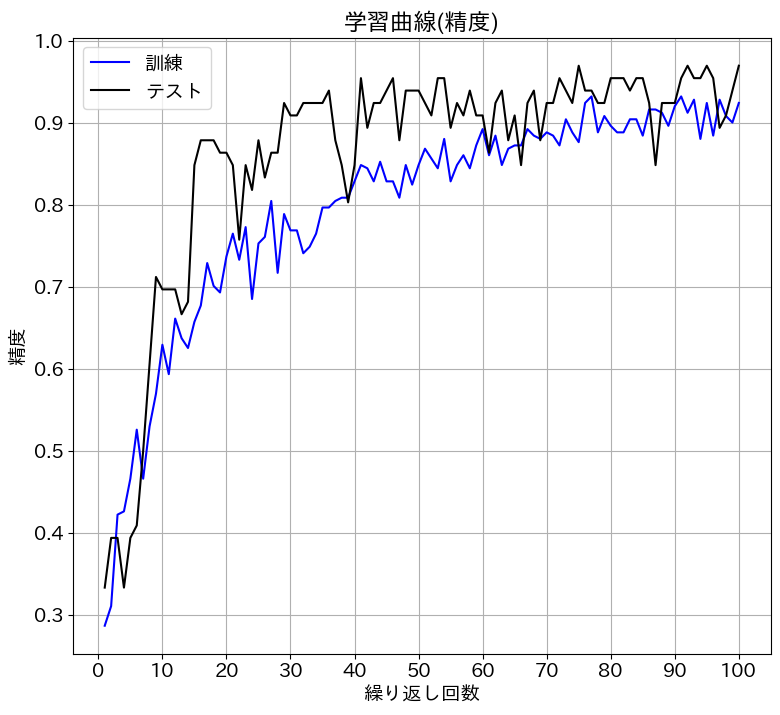

In [58]:
# 結果確認
evaluate_history(history)

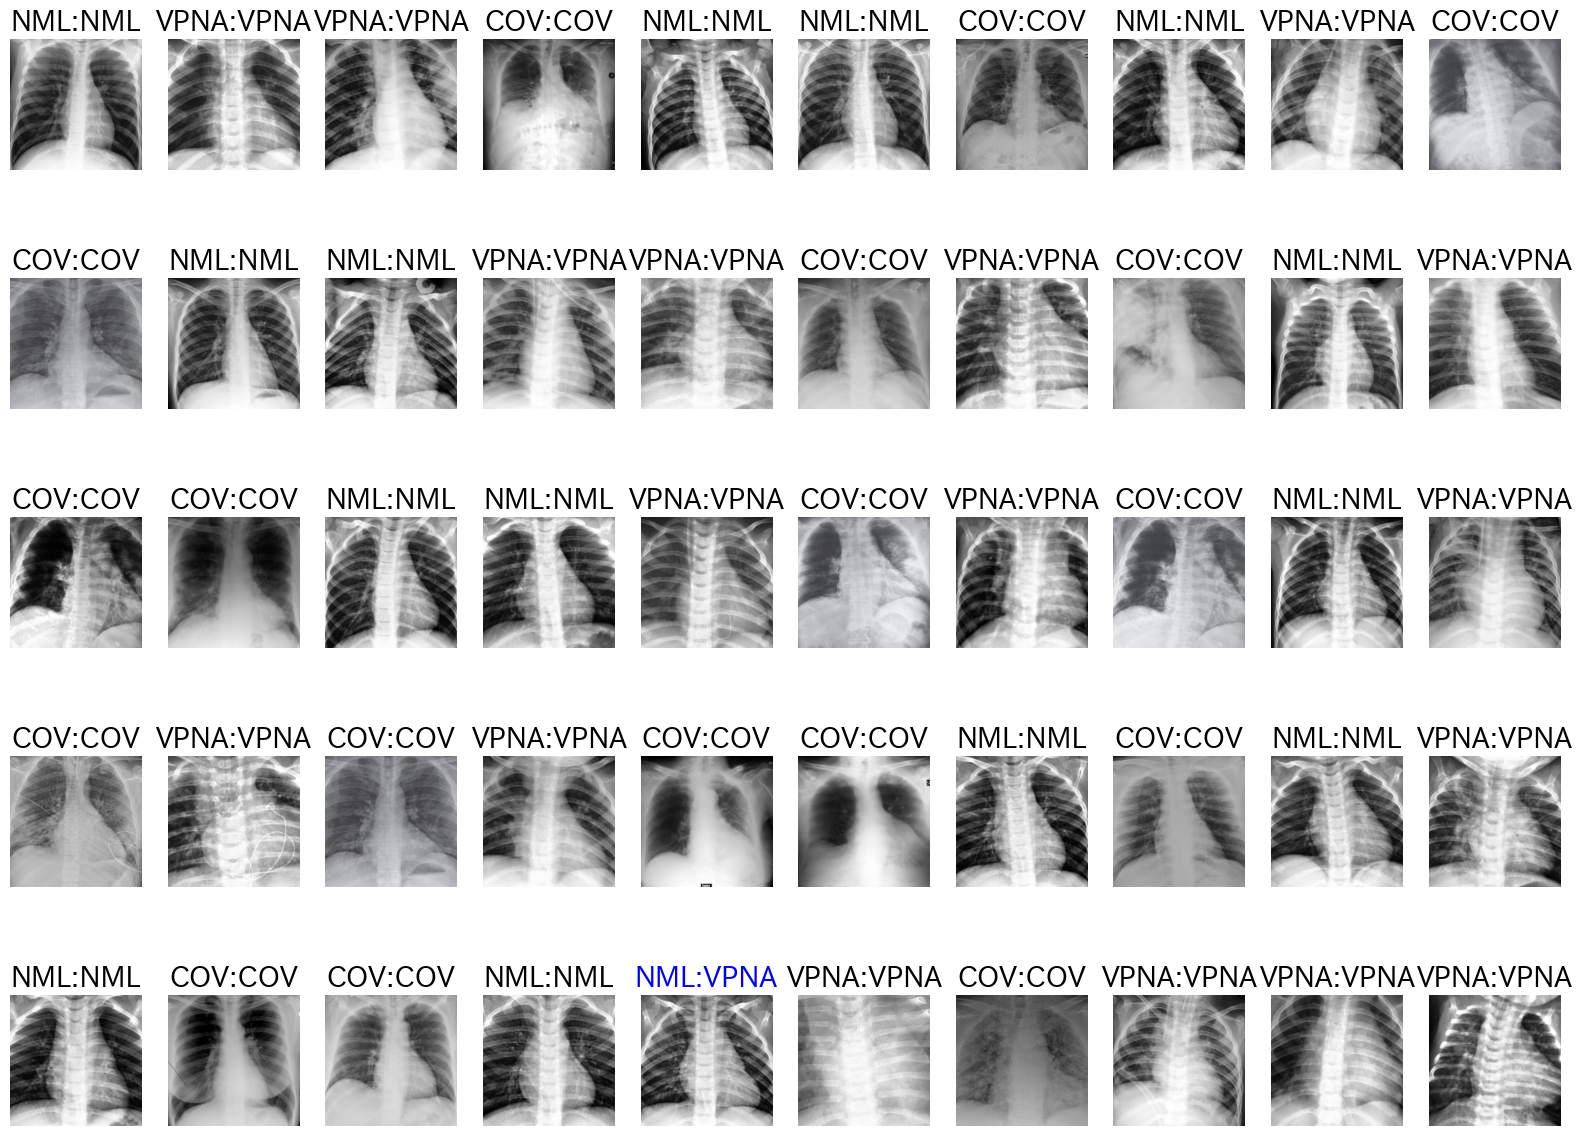

In [59]:
# 乱数初期化
torch_seed()

# 検証データへの結果表示
show_images_labels(test_loader2, classes, net, device)

## 学習率の変更


## 転移学習版

In [45]:
# vgg19_bnをパラメータ付きで読み込む
from torchvision import models
net = models.vgg19_bn(pretrained = True)

# すべてのパラメータで勾配計算なしに
for param in net.parameters():
    param.requires_grad = False

# 乱数初期化
torch_seed()

# 最終ノードの出力を2に変更する
# このノードのみ勾配計算をすることになる
in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, 3)

# AdaptiveAvgPool2d関数の取り外し
net.avgpool = nn.Identity()

# GPUの利用
net = net.to(device)

# 学習率
lr = 0.001

# 損失関数定義
criterion = nn.CrossEntropyLoss()

# 最適化関数定義
# パラメータ修正の対象を最終ノードに限定
optimizer = optim.SGD(net.classifier[6].parameters(),lr=lr,momentum=0.9)

# historyファイルも同時に初期化する
history = np.zeros((0, 5))

In [46]:
# 学習
num_epochs = 20
history = fit(net, optimizer, criterion, num_epochs,
          train_loader, test_loader, device, history)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[1/20],loss:1.11443 acc:0.34263 test_loss:1.0383360241398667 test_acc:0.40909


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[2/20],loss:1.09552 acc:0.43825 test_loss:0.9484448125868132 test_acc:0.54545


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[3/20],loss:1.00062 acc:0.50199 test_loss:1.2018201567909934 test_acc:0.33333


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[4/20],loss:1.06740 acc:0.41036 test_loss:0.8785846287553961 test_acc:0.60606


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[5/20],loss:0.95593 acc:0.50598 test_loss:0.7142916357878483 test_acc:0.69697


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[6/20],loss:0.76344 acc:0.64940 test_loss:0.6592820196440725 test_acc:0.72727


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[7/20],loss:0.78394 acc:0.64542 test_loss:0.9128761526310083 test_acc:0.46970


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[8/20],loss:0.76837 acc:0.65339 test_loss:0.6049729784329733 test_acc:0.80303


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[9/20],loss:0.80128 acc:0.64143 test_loss:0.5884436784368573 test_acc:0.77273


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[10/20],loss:0.71179 acc:0.69323 test_loss:0.5055669654499401 test_acc:0.83333


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[11/20],loss:0.64800 acc:0.72908 test_loss:0.506936411965977 test_acc:0.78788


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[12/20],loss:0.60513 acc:0.74502 test_loss:0.5272383879531514 test_acc:0.81818


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[13/20],loss:0.64906 acc:0.69721 test_loss:0.48433706254670117 test_acc:0.87879


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[14/20],loss:0.67251 acc:0.71713 test_loss:0.6030790534886447 test_acc:0.75758


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[15/20],loss:0.73358 acc:0.68127 test_loss:0.6112248807242422 test_acc:0.75758


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[16/20],loss:0.57374 acc:0.76494 test_loss:0.47832723277987854 test_acc:0.81818


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[17/20],loss:0.63658 acc:0.72908 test_loss:0.5582503080368042 test_acc:0.72727


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[18/20],loss:0.62850 acc:0.71713 test_loss:0.4419966665181247 test_acc:0.86364


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[19/20],loss:0.58054 acc:0.76096 test_loss:0.43801832379716815 test_acc:0.81818


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[20/20],loss:0.49546 acc:0.80478 test_loss:0.5603737253131289 test_acc:0.74242


In [48]:
num_epochs = 1
history = fit(net, optimizer, criterion, num_epochs,
          train_loader, test_loader, device, history)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch[22/22],loss:0.71930 acc:0.68924 test_loss:0.46451609243046155 test_acc:0.83333


初期状態: 損失: 1.03834 精度: 0.40909
最終状態: 損失: 0.46452 精度: 0.83333


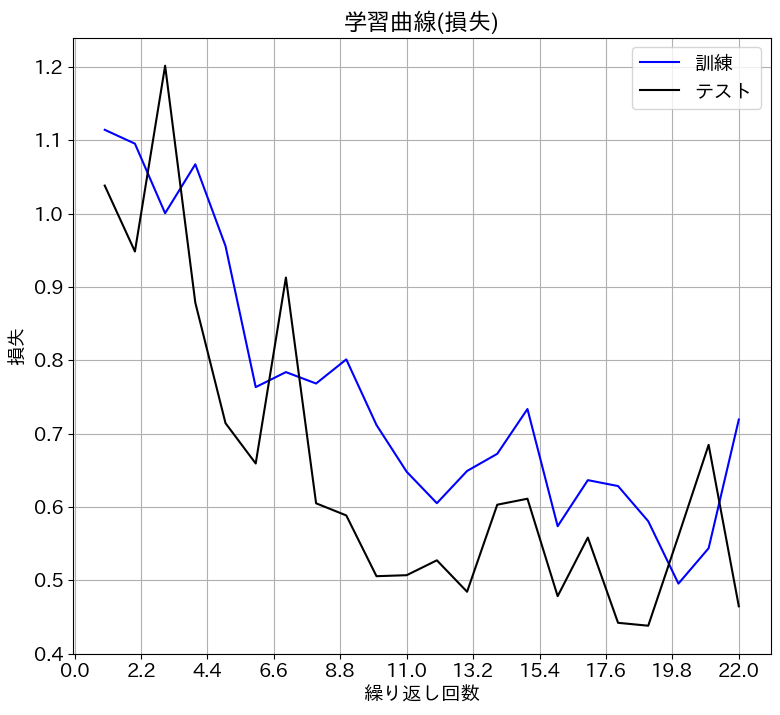

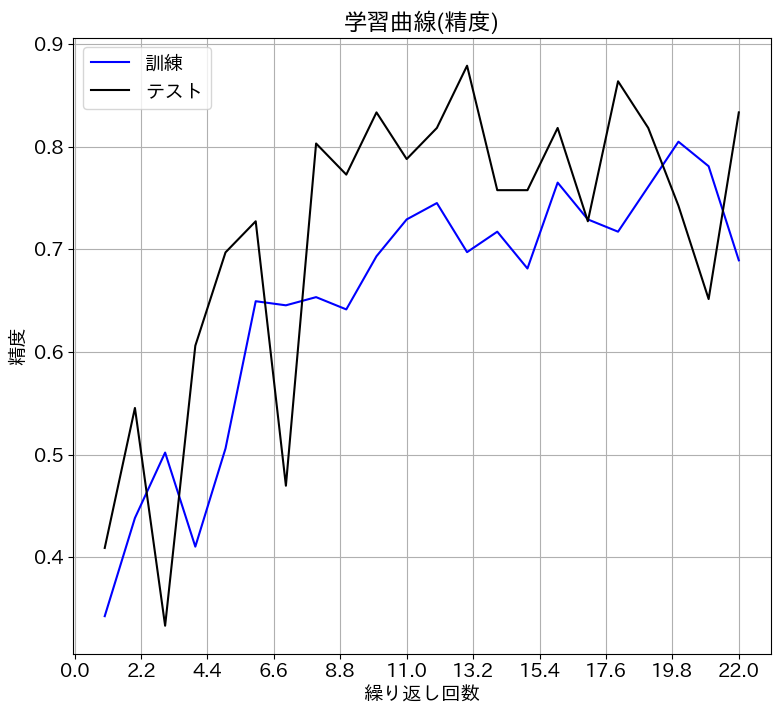

In [49]:
# 結果サマリー
evaluate_history(history)

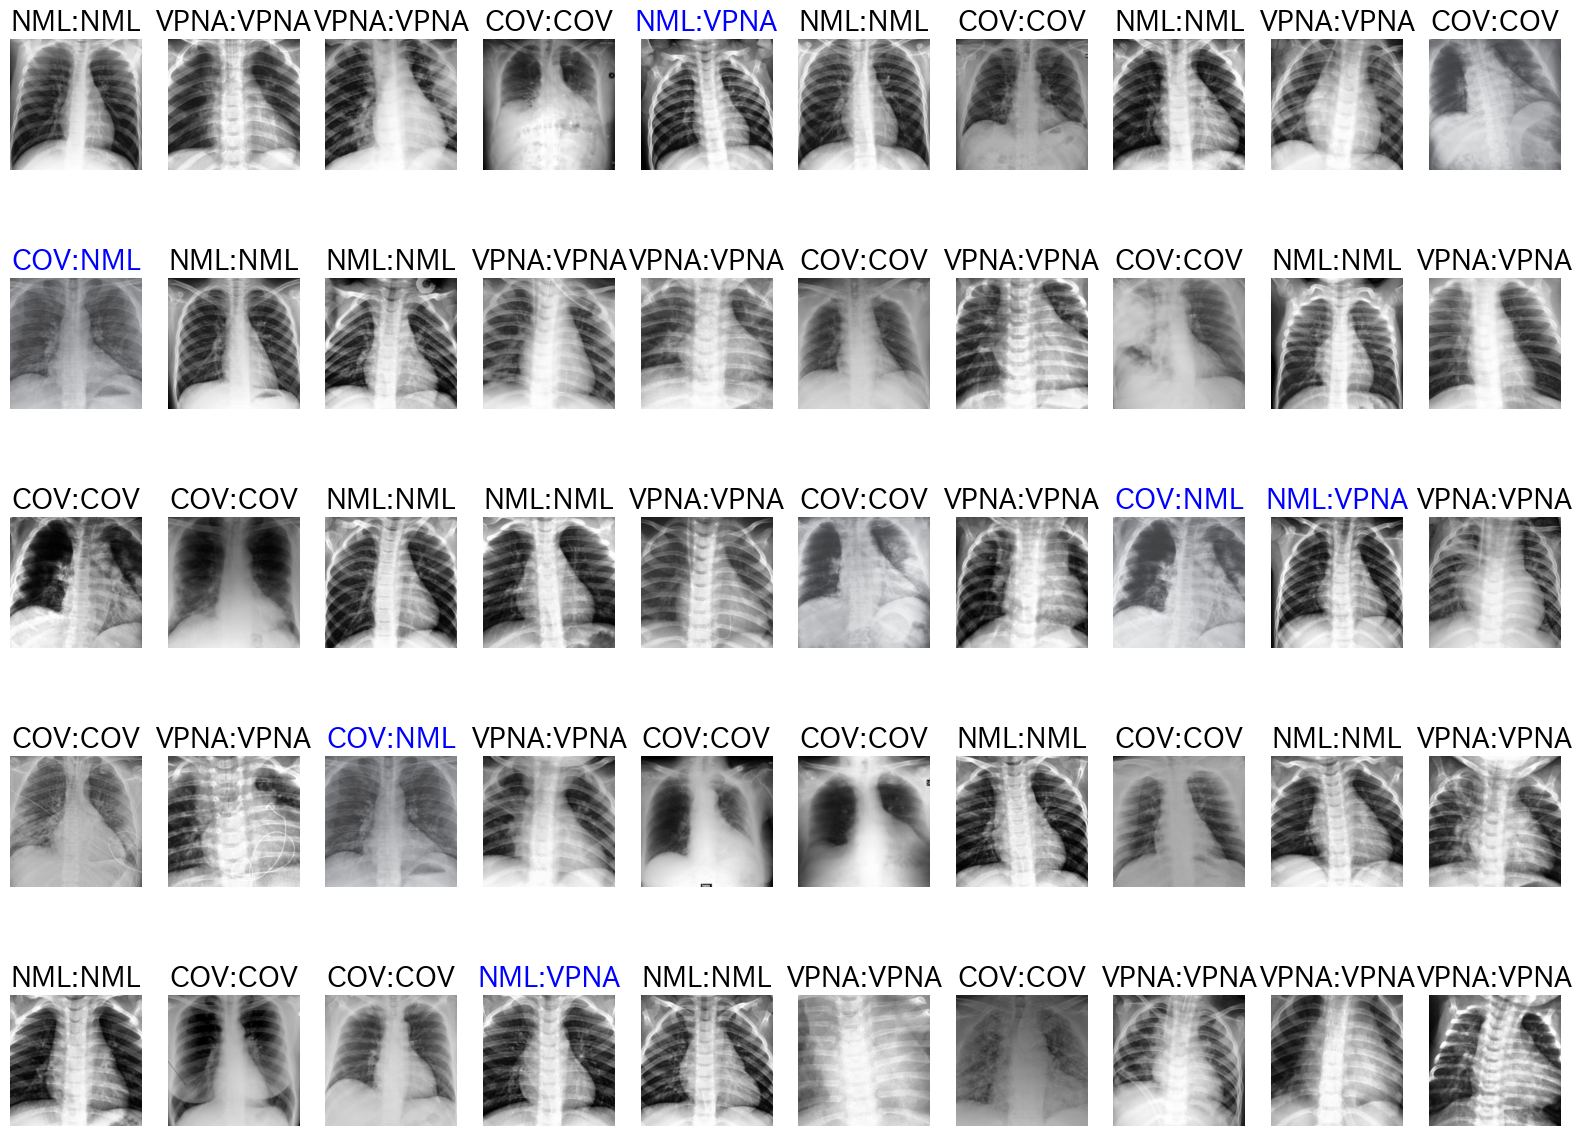

In [50]:
# 乱数初期化
torch_seed()

# テストデータへの結果表示
show_images_labels(test_loader2, classes, net, device)